# Курсовой проект

### Загрузка библиотек

In [3695]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split

In [3696]:
import warnings
warnings.filterwarnings('ignore')

### Загрузка данных

In [3697]:
df_train = pd.read_csv('train.csv')
#test = pd.read_csv('test.csv')
print('Data is loaded!')

Data is loaded!


### Описание данных

* **User_ID** - идентификационный номер покупателя
* **Product_ID** - идентификационный номер товара
* **Gender** - пол покупателя
* **Age** - возраст покупателя
* **Occupation** - род деятельности покупателя
* **City_Category** - город проживания
* **Stay_In_Current_City_Years** - как долго покупатель живет в этом городе
* **Marital_Status** - семейное положение покупателя
* **Product_Category_1** - категория товара 1
* **Product_Category_2** - категория товара 2
* **Product_Category_3** - категория товара 3
* **Purchase** - сумма покупок

In [3698]:
print(f'Train: {df_train.shape[0]} строк и {df_train.shape[1]} признаков')

Train: 80000 строк и 12 признаков


In [3699]:
df_train.columns

Index(['User_ID', 'Product_ID', 'Gender', 'Age', 'Occupation', 'City_Category',
       'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1',
       'Product_Category_2', 'Product_Category_3', 'Purchase'],
      dtype='object')

###  Оптимизация занимаемой памяти

In [3700]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3701]:
df_train = reduce_mem_usage(df_train)

Memory usage of dataframe is 7.32 MB
Memory usage after optimization is: 1.94 MB
Decreased by 73.6%


### Определим признаки

In [3702]:
feature_names = ['User_ID', 'Product_ID', 'Gender', 'Age', 'Occupation', 'City_Category',
       'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1',
       'Product_Category_2', 'Product_Category_3']

target_name = 'Purchase'

In [3703]:
df_train.dtypes

User_ID                          int32
Product_ID                    category
Gender                        category
Age                           category
Occupation                        int8
City_Category                 category
Stay_In_Current_City_Years    category
Marital_Status                    int8
Product_Category_1                int8
Product_Category_2             float32
Product_Category_3             float32
Purchase                         int16
dtype: object

### Изучение признаков

### **Целевая переменная -  target**

In [3704]:
df_train[target_name].describe()

count    80000.000000
mean      9243.933162
std       5021.298356
min         12.000000
25%       5679.750000
50%       8039.000000
75%      12046.000000
max      23961.000000
Name: Purchase, dtype: float64

In [3705]:
target_mean = df_train[target_name].mean()

In [3706]:
target_median = df_train[target_name].median()

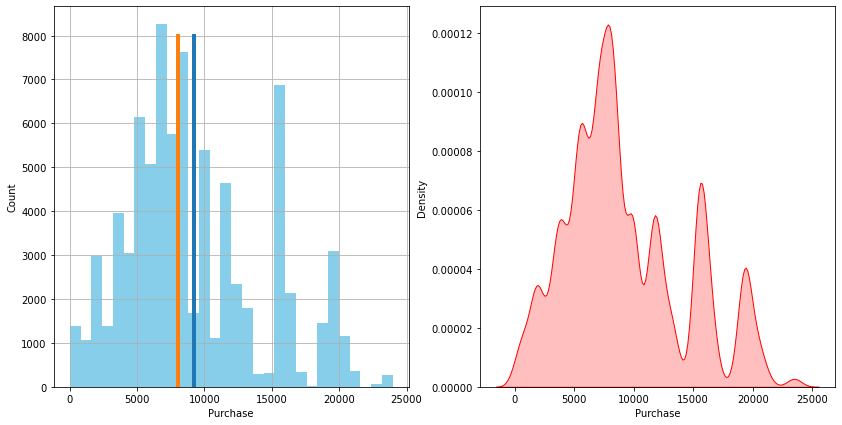

In [3707]:
plt.figure(figsize = (14,7))

plt.subplot(121)
df_train[target_name].hist(bins = 30, color = 'skyblue')
y = np.linspace(0, 8000, 10)
plt.plot([target_mean]*10, y, label='mean',  linewidth=4)
plt.plot([target_median]*10, y, label='median',  linewidth=4)
plt.xlabel('Purchase')
plt.ylabel('Count')

plt.subplot(122)
sns.kdeplot(df_train[target_name], shade = True, color = 'red')

plt.show()

Распределение целевой переменной нельзя назвать нормальным, данные имеют очень широкие неоднородный разброс.

In [3708]:
#Есть сильный неоднородный разброс после значения 14000. Посчитаем количество объектов наблюдений.
df_train.loc[df_train['Purchase'] > 14000, 'Purchase'].count()

16123

In [3709]:
#Количество наблюдений достаточно большое, чтобы от него избавляться.
#df_train = df_train[df_train['Purchase'] < 14000]

In [3710]:
df_train.loc[df_train['Purchase'] > 20000, 'Purchase'].count()

1822

In [3711]:
df_train = df_train[df_train['Purchase'] < 20000]

In [3712]:
#Изучим слишком маленькие суммы покупкок
df_train.loc[df_train[target_name] < 100, target_name].sum()

8783

In [3713]:
#df_train = df_train[df_train['Purchase'] > 100]

Text(0, 0.5, 'Count')

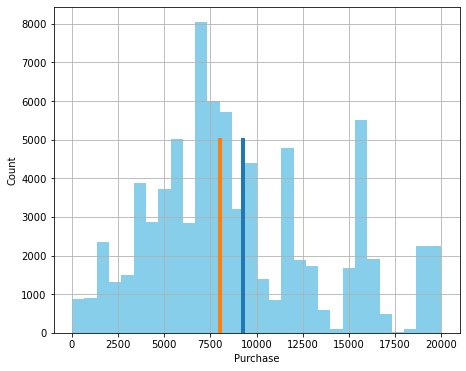

In [3714]:
plt.figure(figsize = (16,6))

plt.subplot(121)
df_train[target_name].hist(bins = 30, color = 'skyblue')
y = np.linspace(0, 5000, 10)
plt.plot([target_mean]*10, y, label='mean',  linewidth=4)
plt.plot([target_median]*10, y, label='median',  linewidth=4)
plt.xlabel('Purchase')
plt.ylabel('Count')

In [3715]:
df_train.shape

(78175, 12)

 ### **Большинство признаков в датасете являются категориальными. Изучим их подробнее**

#### Gender

In [3716]:
gender_counts = df_train['Gender'].value_counts()
gender_counts

M    58653
F    19522
Name: Gender, dtype: int64

Количество покупателей мужчин почти в 3 раза превосходит количество покупателей женщин
Если при изучении значимости признаков окажется, что пол оказывает большое влияние на целевую переменную, необходимо с осторожностью обрабатывать спрос покупателей-женщин, т.к. их доля существенно меньше и ошибки будут иметь бОльший вес

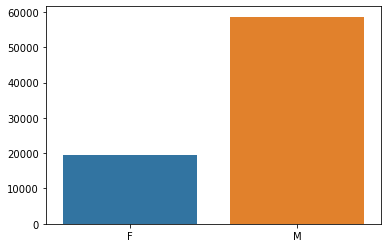

In [3717]:
sns.barplot(gender_counts.index, gender_counts.values)
plt.show()

#### Age

В данном признаке целесообразно определить минимум и максимум для понимания диапазона взраста покупателей

In [3718]:
# Определим количество возрастных групп в наблюдениях:
df_train['Age'].nunique()

7

In [3719]:
# Посмотрим заброс покупателей по возрастным группам:
age_counts = df_train['Age'].value_counts()
age_counts

26-35    31379
36-45    15644
18-25    13960
46-50     6631
51-55     5411
55+       3016
0-17      2134
Name: Age, dtype: int64

Наибольшее количество покупок приходится на возрастную группу 26-35 лет. Можно предположить, что опираясь именно на этот возраст, можно выявить основные тендеции
Самые низкие показатели у покупателей до 18 лет и у покупателей старше 55.

Можно допустить, что небольшая доля покупок у покупалетей до 18 лет связана с ограничениями на площадке продажи

Посмотрим нагляднее:

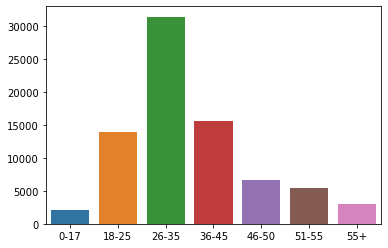

In [3720]:
sns.barplot(age_counts.index, age_counts.values)
plt.show()

In [3721]:
#Изучим соотношение мужчин и жещин в каждой возрастной группе
df_train.groupby(['Age', 'Gender'])['User_ID'].count()

Age    Gender
0-17   F           764
       M          1370
18-25  F          3571
       M         10389
26-35  F          7381
       M         23998
36-45  F          3852
       M         11792
46-50  F          1881
       M          4750
51-55  F          1357
       M          4054
55+    F           716
       M          2300
Name: User_ID, dtype: int64

Более всего бросается в глаза разница в группе 26-35 лет и старше 55 лет

#### Occupation

In [3722]:
df_train['Occupation'].unique()

array([ 6,  7,  3,  0,  4,  1, 20, 18, 14, 17, 16, 10, 12,  2, 15, 19,  9,
       13,  5, 11,  8], dtype=int8)

In [3723]:
df_train['Occupation'].nunique()

21

In [3724]:
occupation_counts = df_train['Occupation'].value_counts()
occupation_counts

4     10214
0      9972
7      8290
1      6782
17     5681
20     4750
12     4452
14     3935
2      3762
16     3634
6      2826
3      2539
10     1840
5      1784
15     1662
11     1656
19     1225
13     1100
18      995
9       843
8       233
Name: Occupation, dtype: int64

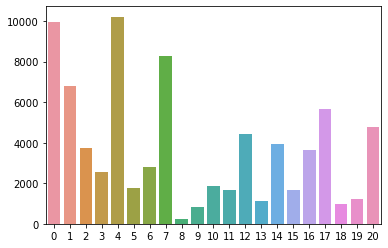

In [3725]:
sns.barplot(occupation_counts.index, occupation_counts.values)
plt.show()

Большая часть покупок приходится на покупателей, работающих в сфере деятельности 0, 1 и 7.

Совсем мало покупок совершают покупатели категории 8 

#### City_Category

In [3726]:
city_counts = df_train['City_Category'].value_counts()
city_counts

B    33020
C    24148
A    21007
Name: City_Category, dtype: int64

<AxesSubplot:>

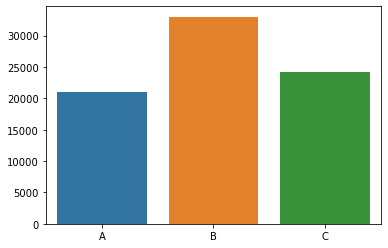

In [3727]:
sns.barplot(city_counts.index, city_counts.values)

Изучаются покупатели в 3 городах, большая часть которых проживает в городе B.
Распределение по городам в целом можно назвать равномерным 

#### Stay_In_Current_City_Years 

In [3728]:
staying_counts = df_train['Stay_In_Current_City_Years'].value_counts()
staying_counts

1     27651
2     14516
3     13508
4+    11949
0     10551
Name: Stay_In_Current_City_Years, dtype: int64

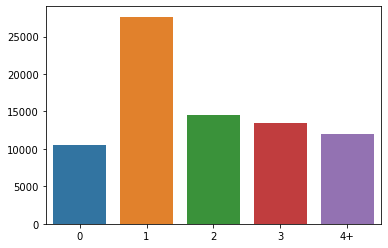

In [3729]:
sns.barplot(staying_counts.index, staying_counts.values)
plt.show()

Наибольшая доля покупателей - проживащие в городе примерно 1 год

Наименьшая у только прибывших, что логично.

In [3730]:
city_group = df_train.groupby(['Stay_In_Current_City_Years', 'City_Category'])['User_ID'].count()
city_group

Stay_In_Current_City_Years  City_Category
0                           A                 3396
                            B                 4140
                            C                 3015
1                           A                 7021
                            B                11929
                            C                 8701
2                           A                 3877
                            B                 5956
                            C                 4683
3                           A                 3552
                            B                 6060
                            C                 3896
4+                          A                 3161
                            B                 4935
                            C                 3853
Name: User_ID, dtype: int64

In [3731]:
#sns.barplot()

#### Marital_Status  

In [3732]:
marital_counts = df_train['Marital_Status'].value_counts()

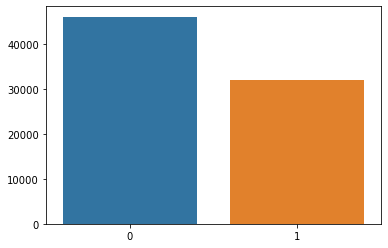

In [3733]:
sns.barplot(marital_counts.index, marital_counts.values)
plt.show()

Сильного разброса между людьми,  находящимися в браке и не в браке нет. 

In [3734]:
df_train.groupby(['Age', 'Marital_Status'])['User_ID'].count()

Age    Marital_Status
0-17   0                  2134
       1                     0
18-25  0                 10979
       1                  2981
26-35  0                 19124
       1                 12255
36-45  0                  9480
       1                  6164
46-50  0                  1835
       1                  4796
51-55  0                  1534
       1                  3877
55+    0                  1084
       1                  1932
Name: User_ID, dtype: int64

В группах до 45 лет большинство покупок делают люди, не находящиеся в браке и с каждой группой разница сокращается. 
После 46 лет доля покупателей в браке существенно превышает долю неженатых. Вероятно, в данном регионе достаточно поздний возраст вступления в брак

До 18 лет вступивших в брак нет - выбросов в данном случае не обнаружено

#### Признаки Product_Category_1, 2 и 3 

Признаки обозначают категории товаров покупателей, детально разбирать каждую категории нецелесообразно

In [3735]:
df_train['Product_Category_1'].unique()

array([ 8,  5,  1,  2,  6, 11,  3,  4,  7, 18, 15, 20, 10, 16, 13, 12, 19,
       14,  9, 17], dtype=int8)

In [3736]:
df_train['Product_Category_1'].nunique()

20

In [3737]:
df_train['Product_Category_2'].unique()

array([14.,  6., 15., 12., nan,  5.,  8., 17., 13., 16., 10., 11.,  2.,
        4.,  9., 18.,  3.,  7.], dtype=float32)

In [3738]:
df_train['Product_Category_2'].nunique()

17

In [3739]:
df_train['Product_Category_3'].unique()

array([nan, 16., 15., 17., 13.,  8., 12.,  5., 18.,  9., 14.,  6.,  3.,
       11., 10.,  4.], dtype=float32)

In [3740]:
df_train['Product_Category_3'].nunique()

15

Наибольшее количество позиций в Product_Category_1.
В Product_Category 2 и 3 одно из значений - nan.
Дополнительно поработаем с ним при обработке пропусков

### Обработка категориальных признаков  - Генерация новых признаков

In [3741]:
df_train.dtypes

User_ID                          int32
Product_ID                    category
Gender                        category
Age                           category
Occupation                        int8
City_Category                 category
Stay_In_Current_City_Years    category
Marital_Status                    int8
Product_Category_1                int8
Product_Category_2             float32
Product_Category_3             float32
Purchase                         int16
dtype: object

Необходимо перевести в количественные типы признаки Product_ID, Gender, Age, City_Category, Stay_In_Current_City_Years

#### Gender
Переведем в дамми

In [3742]:
df_train = pd.concat([df_train, pd.get_dummies(df_train['Gender'])], axis = 1)

In [3743]:
df_train.drop('Gender', axis = 1)
df_train.columns

Index(['User_ID', 'Product_ID', 'Gender', 'Age', 'Occupation', 'City_Category',
       'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1',
       'Product_Category_2', 'Product_Category_3', 'Purchase', 'F', 'M'],
      dtype='object')

In [3744]:
df_train['F'].dtype

dtype('uint8')

In [3745]:
df_train = df_train.drop('Gender', axis = 1)

#### Age
Переведем возрастные группы в категории в порядке увеличения возраста

In [3746]:
df_train['Age'].unique()

['26-35', '18-25', '36-45', '51-55', '0-17', '46-50', '55+']
Categories (7, object): ['26-35', '18-25', '36-45', '51-55', '0-17', '46-50', '55+']

In [3747]:
def age_to_cat(df):
    
    df['age_cat'] = 0
    df.loc[df['Age'] == '0-17', 'age_cat'] = 1
    df.loc[df['Age'] == '18-25', 'age_cat'] = 2
    df.loc[df['Age'] == '26-35', 'age_cat'] = 3
    df.loc[df['Age'] == '36-45', 'age_cat'] = 4
    df.loc[df['Age'] == '46-50', 'age_cat'] = 5
    df.loc[df['Age'] == '50-55', 'age_cat'] = 6
    df.loc[df['Age'] == '55+', 'age_cat'] = 7
    
    return df

In [3748]:
df_train = age_to_cat(df_train)

In [3749]:
#df_train = df_train.drop('Age', axis = 1)
#df_train.head()

#### City_Category

In [3750]:
df_train['City_Category'].unique()

['A', 'C', 'B']
Categories (3, object): ['A', 'C', 'B']

Переведем в дамми

In [3751]:
df_train = pd.concat([df_train, pd.get_dummies(df_train['City_Category'])], axis = 1)

In [3752]:
df_train.rename(columns = {'A': 'City_Category_A', 'B': 'City_Category_B', 'C': 'City_Category_C'}, inplace = True)
#df_train = df_train.drop('City_Category', axis = 1)
df_train.head()

,User_ID,Product_ID,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,F,M,age_cat,City_Category_A,City_Category_B,City_Category_C
0,1004085,P00075742,26-35,6,A,1,0,8,14.0,NaN,7803,1,0,3,1,0,0
1,1005491,P00234842,18-25,7,A,1,0,5,6.0,16.0,6903,0,1,2,1,0,0
2,1003499,P00220142,26-35,3,A,2,0,1,15.0,NaN,15773,0,1,3,1,0,0
3,1000097,P00211242,36-45,3,C,3,0,8,12.0,NaN,8116,1,0,4,0,0,1
4,1005802,P00327142,26-35,0,A,4+,0,8,15.0,NaN,6144,1,0,3,1,0,0


#### Stay_In_Current_City_Years

Переведем в категории по увеличению времени проживания в городе

In [3753]:
df_train['Stay_In_Current_City_Years'].unique()

['1', '2', '3', '4+', '0']
Categories (5, object): ['1', '2', '3', '4+', '0']

In [3754]:
def stay_in_city_to_cat(df):
    
    df['stay_in_city_cat'] = 0
    df.loc[df['Stay_In_Current_City_Years'] == '0', 'stay_in_city_cat'] = 1
    df.loc[df['Stay_In_Current_City_Years'] == '1', 'stay_in_city_cat'] = 2
    df.loc[df['Stay_In_Current_City_Years'] == '2', 'stay_in_city_cat'] = 3
    df.loc[df['Stay_In_Current_City_Years'] == '3', 'stay_in_city_cat'] = 4
    df.loc[df['Stay_In_Current_City_Years'] == '4+', 'stay_in_city_cat'] = 5
    
    return df

In [3755]:
df_train = stay_in_city_to_cat(df_train)

In [3756]:
#df_train = df_train.drop('Stay_In_Current_City_Years', axis = 1)
#df_train.head()

In [3757]:
df_train.dtypes

User_ID                          int32
Product_ID                    category
Age                           category
Occupation                        int8
City_Category                 category
Stay_In_Current_City_Years    category
Marital_Status                    int8
Product_Category_1                int8
Product_Category_2             float32
Product_Category_3             float32
Purchase                         int16
F                                uint8
M                                uint8
age_cat                          int64
City_Category_A                  uint8
City_Category_B                  uint8
City_Category_C                  uint8
stay_in_city_cat                 int64
dtype: object

#### Product_ID

In [3758]:
df_train['Product_ID'] = df_train['Product_ID'].map(lambda x: str(x)[1:]) 
df_train.head()

,User_ID,Product_ID,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,F,M,age_cat,City_Category_A,City_Category_B,City_Category_C,stay_in_city_cat
0,1004085,00075742,26-35,6,A,1,0,8,14.0,NaN,7803,1,0,3,1,0,0,2
1,1005491,00234842,18-25,7,A,1,0,5,6.0,16.0,6903,0,1,2,1,0,0,2
2,1003499,00220142,26-35,3,A,2,0,1,15.0,NaN,15773,0,1,3,1,0,0,3
3,1000097,00211242,36-45,3,C,3,0,8,12.0,NaN,8116,1,0,4,0,0,1,4
4,1005802,00327142,26-35,0,A,4+,0,8,15.0,NaN,6144,1,0,3,1,0,0,5


In [3759]:
df_train['Product_ID'] = df_train['Product_ID'].astype(int)
df_train['Product_ID'].dtype

dtype('int64')

**Посмотрим имующиеся теперь типы данных**

In [3760]:
df_train.dtypes

User_ID                          int32
Product_ID                       int64
Age                           category
Occupation                        int8
City_Category                 category
Stay_In_Current_City_Years    category
Marital_Status                    int8
Product_Category_1                int8
Product_Category_2             float32
Product_Category_3             float32
Purchase                         int16
F                                uint8
M                                uint8
age_cat                          int64
City_Category_A                  uint8
City_Category_B                  uint8
City_Category_C                  uint8
stay_in_city_cat                 int64
dtype: object

In [3761]:
df_train.columns

Index(['User_ID', 'Product_ID', 'Age', 'Occupation', 'City_Category',
       'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1',
       'Product_Category_2', 'Product_Category_3', 'Purchase', 'F', 'M',
       'age_cat', 'City_Category_A', 'City_Category_B', 'City_Category_C',
       'stay_in_city_cat'],
      dtype='object')

### Обработка пропусков

In [3762]:
df_train.isnull().sum()

User_ID                           0
Product_ID                        0
Age                               0
Occupation                        0
City_Category                     0
Stay_In_Current_City_Years        0
Marital_Status                    0
Product_Category_1                0
Product_Category_2            24491
Product_Category_3            54267
Purchase                          0
F                                 0
M                                 0
age_cat                           0
City_Category_A                   0
City_Category_B                   0
City_Category_C                   0
stay_in_city_cat                  0
dtype: int64

Изучим дополнительно признаки Product_Category_2 & 3, содержащие большое количество пропусков

Создадим дополнительный столбец для обоих признаков, заполнив его значениями 0, если пропусков нет, и значениями 1, если пропуски есть

In [3763]:
df_train['Product_Cat_2_Null'] = 0

In [3764]:
df_train.loc[df_train['Product_Category_2'].isnull(), 'Product_Cat_2_Null'] = 1

In [3765]:
df_train['Product_Cat_3_Null'] = 0

In [3766]:
df_train.loc[df_train['Product_Category_3'].isnull(), 'Product_Cat_3_Null'] = 1

**Функция для заполнения пропусков**

In [3767]:
def fill_nan_predictor(data, target_col):
    data = data.copy()
    
    features = data.columns
    
    data = data[features]
    
    train = data[~data[target_col].isna()]
    predict_data = data[data[target_col].isna()]

    X = train.drop(columns=target_col)
    y = train[target_col]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        random_state=32)
    
    model = RandomForestRegressor(n_estimators=100,
                                  max_depth=10,
                                  random_state=42,
                                  verbose=1)
    model.fit(X_train, y_train)
    
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    print(f"r2 на train: {r2_score(y_train, pred_train)}")
    print(f"r2 на test: {r2_score(y_test, pred_test)}")

    pred = model.predict(predict_data.drop(columns=target_col))

    data.loc[data[target_col].isna(), target_col] = list(pred)
    return model, data

#### Product_Category_2

In [3768]:
df_train['Product_Category_2'].value_counts()

8.0     8891
14.0    8040
2.0     7062
16.0    6078
15.0    5387
5.0     3880
4.0     3823
6.0     2427
11.0    2064
17.0    1871
13.0    1414
12.0     798
9.0      784
18.0     400
3.0      378
10.0     300
7.0       87
Name: Product_Category_2, dtype: int64

In [3769]:
df_train['Product_Category_2'].isnull().sum()

24491

In [3770]:
df_train.columns

Index(['User_ID', 'Product_ID', 'Age', 'Occupation', 'City_Category',
       'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1',
       'Product_Category_2', 'Product_Category_3', 'Purchase', 'F', 'M',
       'age_cat', 'City_Category_A', 'City_Category_B', 'City_Category_C',
       'stay_in_city_cat', 'Product_Cat_2_Null', 'Product_Cat_3_Null'],
      dtype='object')

В связи с большим количеством пропусков, наиболее удачным вариантом было бы их заполнить с помощью модели на основе признаков, в котором(х) нет пропущенных значений
Предположительно, этот вариант заполнения будет наиболее удачным в данном случае, нежели заполнять медианой или средним

In [3771]:
df_copy = df_train.copy()
df_copy = df_copy.drop(['User_ID', 'Age', 'Occupation', 'City_Category',
       'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_3', 'City_Category_A', 'City_Category_B',
        'F', 'M', 'age_cat', 'City_Category_C', 'Purchase', 'stay_in_city_cat', 'Product_Cat_3_Null'], axis = 1)
df_copy.columns

Index(['Product_ID', 'Product_Category_1', 'Product_Category_2',
       'Product_Cat_2_Null'],
      dtype='object')

In [3772]:
df_train.drop('Product_Category_2', axis = 1, inplace = True)

In [3773]:
feature_name = 'Product_Category_2'
df_copy[feature_name].isnull().sum()

24491

In [3774]:
prod_cat_2_predictor, df_copy = fill_nan_predictor(df_copy, feature_name)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


r2 на train: 0.7920222459458738
r2 на test: 0.7952541054169334


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


In [3775]:
df_copy[feature_name].isnull().sum()

0

In [3776]:
df_train = pd.concat([df_train, df_copy[feature_name]], axis =1)

In [3777]:
df_train.columns

Index(['User_ID', 'Product_ID', 'Age', 'Occupation', 'City_Category',
       'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1',
       'Product_Category_3', 'Purchase', 'F', 'M', 'age_cat',
       'City_Category_A', 'City_Category_B', 'City_Category_C',
       'stay_in_city_cat', 'Product_Cat_2_Null', 'Product_Cat_3_Null',
       'Product_Category_2'],
      dtype='object')

#### Product_Category_3

In [3778]:
df_train['Product_Category_3'].value_counts()

16.0    4514
15.0    4055
14.0    2664
17.0    2420
5.0     2386
8.0     1805
9.0     1755
12.0    1403
6.0      725
18.0     689
13.0     669
11.0     257
4.0      253
10.0     220
3.0       93
Name: Product_Category_3, dtype: int64

In [3779]:
df_train['Product_Category_3'].isnull().sum()

54267

In [3780]:
df_train.loc[df_train['Product_Category_3'].isnull(), 'Product_Cat_3_Null'] = 1

Пропущенных значений более 50%. 
Рассмотрим 2 варианта, попробуем построить модель без этого признака вообще, и с этим признаком с пропуками, заполненными предсказанными значениями

In [3781]:
df_copy = df_train.copy()

In [3782]:
df_copy = df_copy.drop(['User_ID', 'Age', 'Occupation', 'City_Category',
       'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_2', 'City_Category_A', 'City_Category_B',
        'F', 'M', 'age_cat', 'City_Category_C', 'Purchase', 'stay_in_city_cat', 'Product_Cat_2_Null'], axis = 1)
df_copy.columns

Index(['Product_ID', 'Product_Category_1', 'Product_Category_3',
       'Product_Cat_3_Null'],
      dtype='object')

In [3783]:
df_train.drop('Product_Category_3', axis = 1, inplace = True)

In [3784]:
feature_name = 'Product_Category_3'

In [3785]:
prod_cat_3_predictor, df_copy = fill_nan_predictor(df_copy, feature_name)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


r2 на train: 0.7855193418203401
r2 на test: 0.7755673182810088


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


In [3786]:
df_copy[feature_name].isnull().sum()

0

In [3787]:
df_train = pd.concat([df_train, df_copy[feature_name]], axis = 1)
df_train.columns

Index(['User_ID', 'Product_ID', 'Age', 'Occupation', 'City_Category',
       'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1',
       'Purchase', 'F', 'M', 'age_cat', 'City_Category_A', 'City_Category_B',
       'City_Category_C', 'stay_in_city_cat', 'Product_Cat_2_Null',
       'Product_Cat_3_Null', 'Product_Category_2', 'Product_Category_3'],
      dtype='object')

In [3788]:
#Убедимся, что не осталось пропусков
df_train.isnull().sum()

User_ID                       0
Product_ID                    0
Age                           0
Occupation                    0
City_Category                 0
Stay_In_Current_City_Years    0
Marital_Status                0
Product_Category_1            0
Purchase                      0
F                             0
M                             0
age_cat                       0
City_Category_A               0
City_Category_B               0
City_Category_C               0
stay_in_city_cat              0
Product_Cat_2_Null            0
Product_Cat_3_Null            0
Product_Category_2            0
Product_Category_3            0
dtype: int64

Сейчас полученные предсказанием значения имеют много знаков после запятой, приведем их к типу int, как и Product_Category_1

In [3789]:
df_train['Product_Category_2'] = df_train['Product_Category_2'].astype(int)
df_train['Product_Category_3'] = df_train['Product_Category_3'].astype(int)

In [3790]:
df_train['Product_ID'].value_counts()

265242    272
25442     225
112142    224
58042     221
110742    220
         ... 
258142      1
339642      1
232942      1
19542       1
290642      1
Name: Product_ID, Length: 3250, dtype: int64

### Построение матрицы корреляций

<AxesSubplot:>

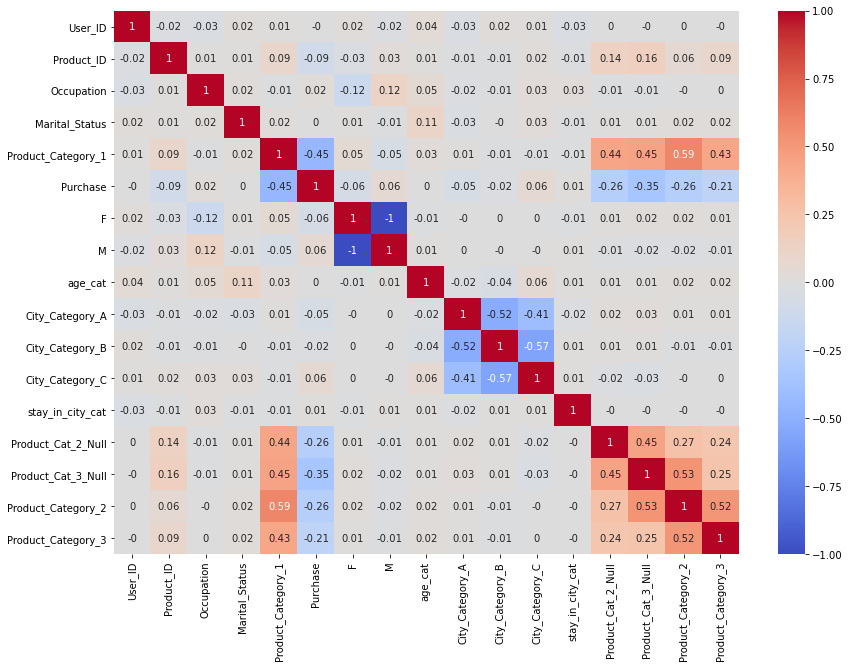

In [3791]:
corr_matrix = df_train.corr()
corr_matrix = np.round(corr_matrix, 2)
plt.figure(figsize = (14,10))
sns.heatmap(corr_matrix, annot = True, cmap = 'coolwarm')

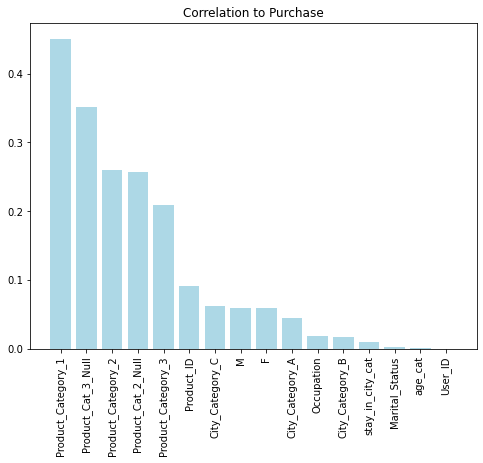

In [3792]:
corr_matrix = df_train.corrwith(df_train['Purchase'])
corr_matrix = df_train.loc[:, df_train.columns != 'Purchase'].corrwith(df_train['Purchase']).abs().sort_values(ascending=False)
plt.figure(figsize = (8, 6))
plt.bar(corr_matrix.index, corr_matrix.values, color = 'lightblue')
plt.title('Correlation to Purchase')
plt.xticks(rotation='vertical')
plt.show()

###  Анализ зависимости таргета от признаков

Изучим влияние отдельных признаков на целевую переменную

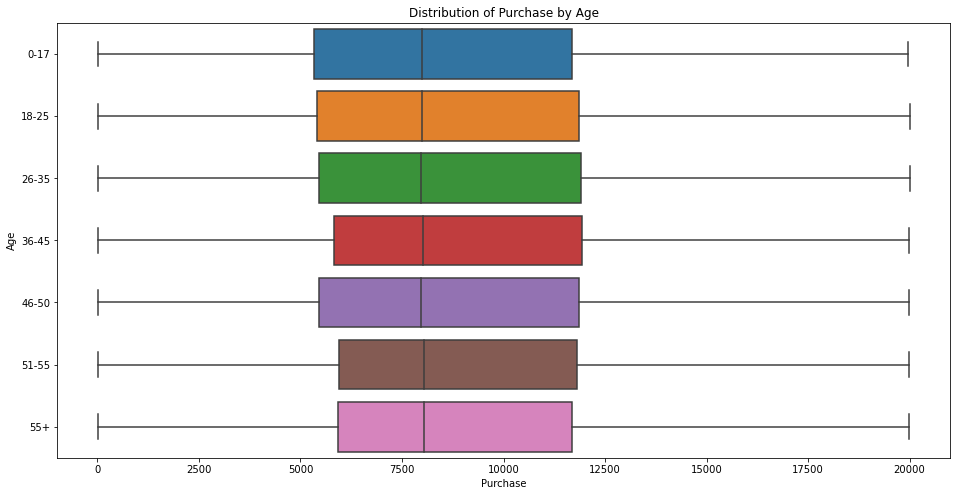

In [3793]:
plt.figure(figsize=(16, 8))

sns.boxplot(df_train['Purchase'], df_train['Age'], whis=1.5)

plt.xlabel('Purchase')
plt.ylabel('Age')
plt.title('Distribution of Purchase by Age')
plt.show()

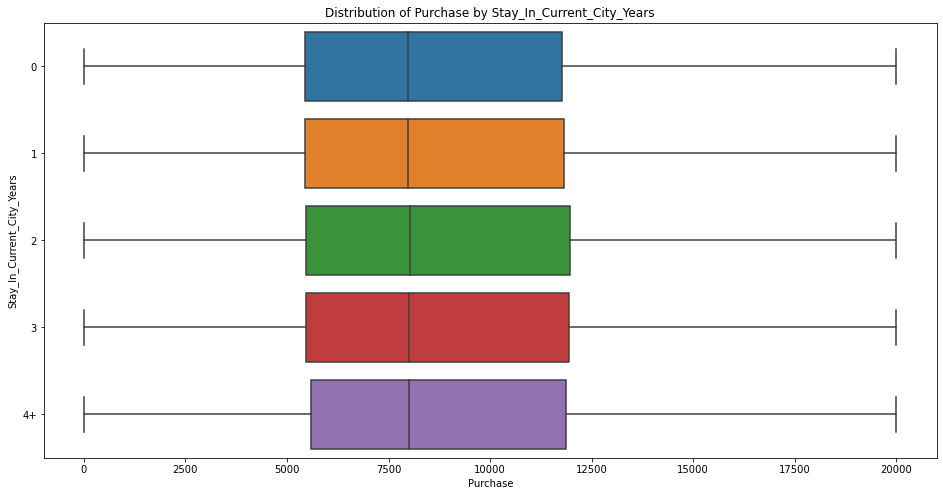

In [3794]:
plt.figure(figsize=(16, 8))

sns.boxplot(df_train['Purchase'], df_train['Stay_In_Current_City_Years'], whis=1.5)

plt.xlabel('Purchase')
plt.ylabel('Stay_In_Current_City_Years')
plt.title('Distribution of Purchase by Stay_In_Current_City_Years')
plt.show()

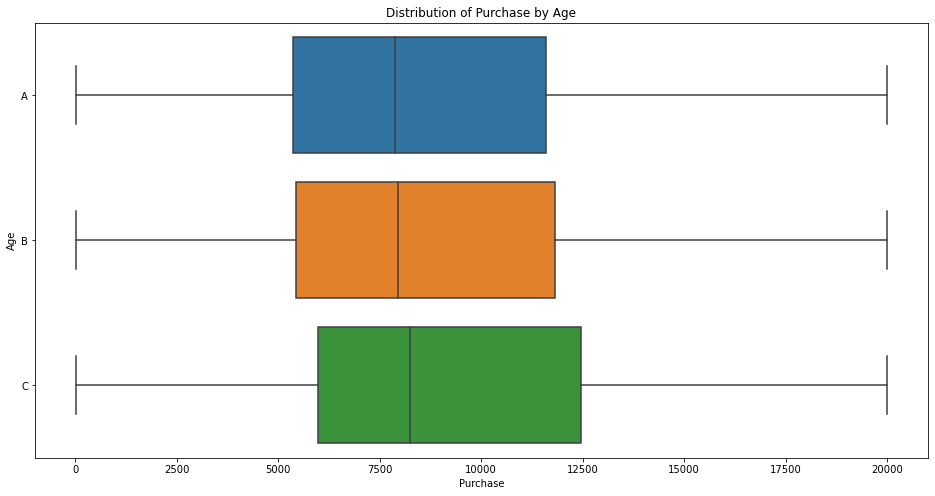

In [3795]:
plt.figure(figsize=(16, 8))

sns.boxplot(df_train['Purchase'], df_train['City_Category'], whis=1.5)

plt.xlabel('Purchase')
plt.ylabel('Age')
plt.title('Distribution of Purchase by Age')
plt.show()

ВЫВОД

###  Переопределение признаков

In [3796]:
df_train.columns

Index(['User_ID', 'Product_ID', 'Age', 'Occupation', 'City_Category',
       'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1',
       'Purchase', 'F', 'M', 'age_cat', 'City_Category_A', 'City_Category_B',
       'City_Category_C', 'stay_in_city_cat', 'Product_Cat_2_Null',
       'Product_Cat_3_Null', 'Product_Category_2', 'Product_Category_3'],
      dtype='object')

Уберем категориальные признаки, оставляя их количественное представление

In [3859]:
# также не будем учитывать User_ID, 'Product_Cat_2_Null','Product_Cat_3_Null', 'F', 'M', 'age_cat', 
feature_names = ['Product_ID', 'Occupation', 'Marital_Status',
                 'Product_Category_1', 'City_Category_A', 'City_Category_B', 'City_Category_C', 
                 'stay_in_city_cat',  'Product_Category_3',
                 'Product_Category_2']

target_name = 'Purchase'


In [3860]:
df_train[feature_names].head()

,Product_ID,Occupation,Marital_Status,Product_Category_1,City_Category_A,City_Category_B,City_Category_C,stay_in_city_cat,Product_Category_3,Product_Category_2
0,75742,6,0,8,1,0,0,2,17,14
1,234842,7,0,5,1,0,0,2,16,6
2,220142,3,0,1,1,0,0,3,5,15
3,211242,3,0,8,0,0,1,4,16,12
4,327142,0,0,8,1,0,0,5,16,15


###  Разбиение на train и test

In [3861]:
X = df_train[feature_names]
y = df_train[target_name]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = True, random_state = 42)

In [3862]:
X.columns

Index(['Product_ID', 'Occupation', 'Marital_Status', 'Product_Category_1',
       'City_Category_A', 'City_Category_B', 'City_Category_C',
       'stay_in_city_cat', 'Product_Category_3', 'Product_Category_2'],
      dtype='object')

###   Построение различных моделей и выбор лучшей

In [3863]:
def create_model(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2_score(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2_score(test_true_values, test_pred_values), 3)))

In [3864]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

create_model(y_train, y_train_pred_rf, y_test, y_test_pred_rf)

Train R2:	0.935
Test R2:	0.643


Попробуем подобрать гиперпараметры

In [3865]:
parametres = {'n_estimators': [50, 75, 100, 150],
             'max_features': [5, 7, 9],
             'max_depth': [5, 7, 10, 12]}

In [3866]:
rf_model = GridSearchCV(estimator = RandomForestRegressor(random_state = 42),
                       param_grid = parametres,
                       scoring = 'r2',
                       cv = 5)

In [3867]:
rf_model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [5, 7, 10, 12], 'max_features': [5, 7, 9],
                         'n_estimators': [50, 75, 100, 150]},
             scoring='r2')

In [3868]:
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

create_model(y_train, y_train_pred_rf, y_test, y_test_pred_rf)

Train R2:	0.731
Test R2:	0.677


In [3869]:
rf_model.best_params_

{'max_depth': 12, 'max_features': 9, 'n_estimators': 150}